Install & Import Libraries

In [ ]:
# !pip install -q sentence-transformers xgboost

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sentence_transformers import SentenceTransformer
import joblib
import json
import os
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)


Load Dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/RESUME_SEG/Dataset (1).txt")
print(df.shape)
df.head()


(13389, 2)


,Category,Text
0,Accountant,﻿________________\r\n\r\nEDUCATION\r\nOMBA - Executive Leadership University of Texas\r\n2016-20...
1,Accountant,"﻿________________\r\n\r\nHOWARD GERRARD\r\nAccountant\r\nDeyjob.com, Birmingham\r\n0123 456 7890..."
2,Accountant,﻿________________\r\n\r\nKevin Frank\r\nSENIOR ACCOUNTANT\r\ninfo@resumekraft.com\r\n202-555-012...
3,Accountant,"﻿________________\r\n\r\nPlace of birth\r\nNationality\r\nOlivia Ogilvy, Accountant\r\n1515 Paci..."
4,Accountant,"﻿________________\r\n\r\nStephen Greet, CPA\r\nSenior Accountant\r\nThrough my 9+ year of experi..."


Dataset Summary

In [ ]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13389 entries, 0 to 13388
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  13389 non-null  object
 1   Text      13389 non-null  object
dtypes: object(2)
memory usage: 209.3+ KB


,0
Category,0
Text,0


Category Distribution

In [ ]:
category_counts = df['Category'].value_counts()
print(category_counts)
print("Unique Categories:", df['Category'].nunique())


Category
Education                    410
Electrical Engineering       384
Mechanical Engineer          384
Consultant                   368
Sales                        364
Civil Engineer               364
Management                   361
Human Resources              360
Digital Media                358
Accountant                   350
Java Developer               348
Operations Manager           345
Building and Construction    345
Testing                      344
Architecture                 344
Aviation                     340
Business Analyst             340
Finance                      339
SQL Developer                338
Public Relations             337
Health and Fitness           332
Arts                         332
Network Security Engineer    330
DotNet Developer             329
Apparel                      320
Banking                      314
Automobile                   313
Web Designing                309
SAP Developer                304
Data Science                 299
E

Bar Chart of Categories

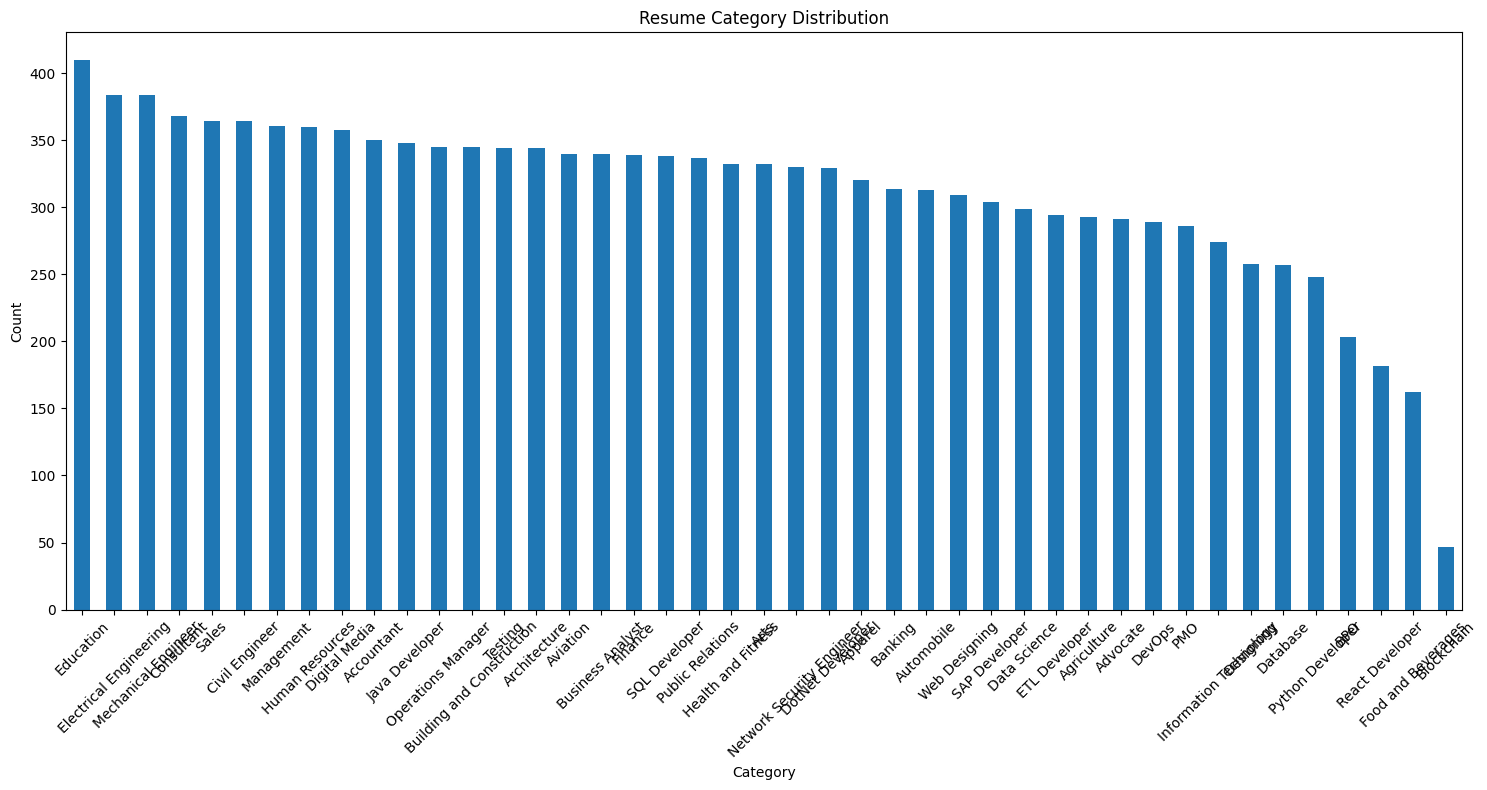

In [ ]:
plt.figure(figsize=(15, 8))
category_counts.plot(kind='bar')
plt.title('Resume Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Pie Chart of Categories

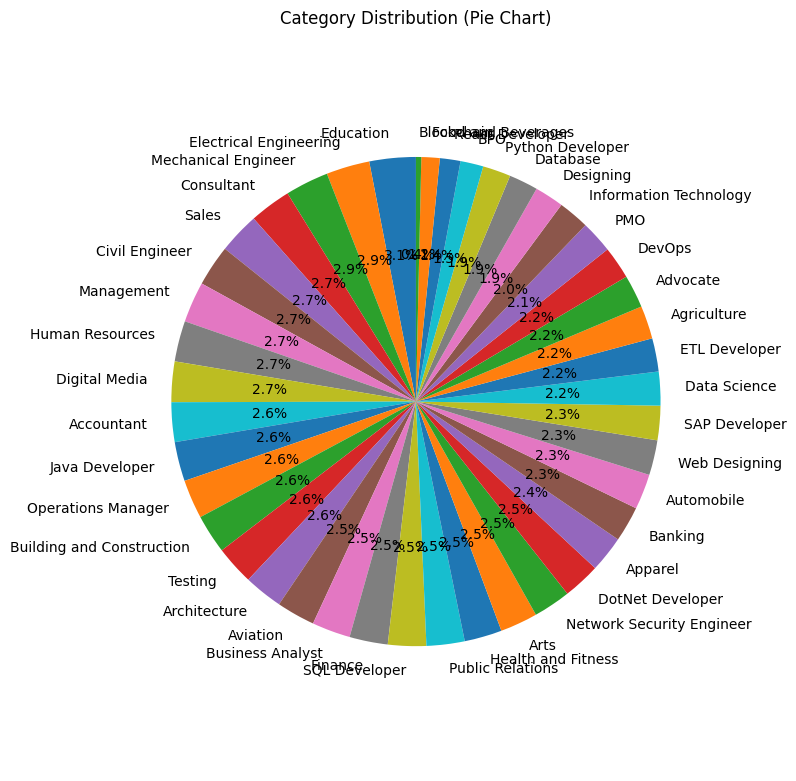

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Category Distribution (Pie Chart)')
plt.axis('equal')
plt.tight_layout()
plt.show()


Clean Text

In [ ]:
def clean_resume_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\+?\d[\d\s\-\(\)]{8,}\d', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['resume_length'] = df['Text'].str.len()
df['cleaned_resume'] = df['Text'].apply(clean_resume_text)
df['cleaned_length'] = df['cleaned_resume'].str.len()
df = df[df['cleaned_length'] > 50].drop_duplicates(subset=['cleaned_resume'])

print("Cleaned dataset shape:", df.shape)


Cleaned dataset shape: (12044, 5)


Generate Sentence Embeddings

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')
resume_embeddings = model.encode(df['cleaned_resume'].tolist(), show_progress_bar=True)

np.save('/content/drive/MyDrive/RESUME_SEG/resume_embeddings.npy', resume_embeddings)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/377 [00:00<?, ?it/s]

Prepare Train-Test Split

In [ ]:
X = resume_embeddings
y = df['Category'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

Train size: 9635 Test size: 2409


Train Base Random Forest

In [ ]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"✅ Base RF Accuracy: {rf_accuracy:.4f}")


✅ Base RF Accuracy: 0.6945


Hyperparameter Tuning (Random Forest)

In [ ]:
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_distributions=param_dist_rf,
    n_iter=10,
    cv=3,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)
print("Best Random Forest Params:", rf_random.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Random Forest Params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}


Evaluate Tuned RF

In [ ]:
best_rf_model = rf_random.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
rf_tuned_acc = accuracy_score(y_test, y_pred_rf)
print(f"🏆 Tuned RF Accuracy: {rf_tuned_acc:.4f}")


🏆 Tuned RF Accuracy: 0.7240


Save RF Model

In [ ]:
joblib.dump(best_rf_model, '/content/drive/MyDrive/RESUME_SEG/rf_tuned.pkl')


['/content/drive/MyDrive/RESUME_SEG/rf_tuned.pkl']

Train XGBoost (Initial)

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_encoded)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, y_pred_xgb)
print(f"✅ XGBoost Initial Accuracy: {xgb_acc:.4f}")


✅ XGBoost Initial Accuracy: 0.6924


XGBoost Hyperparameter Tuning

In [ ]:
param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}

xgb_random = RandomizedSearchCV(
    estimator=XGBClassifier(
        objective='multi:softprob',
        num_class=len(np.unique(y_encoded)),
        use_label_encoder=False,
        eval_metric='mlogloss',
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        random_state=42
    ),
    param_distributions=param_dist_xgb,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

xgb_random.fit(X_train, y_train)
print("✅ Best XGBoost Params:", xgb_random.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best XGBoost Params: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.6}


Evaluate Tuned XGBoost

In [ ]:
xgb_best_model = xgb_random.best_estimator_
y_pred_best_xgb = xgb_best_model.predict(X_test)
xgb_best_acc = accuracy_score(y_test, y_pred_best_xgb)
print(f"🏆 Tuned XGBoost Accuracy: {xgb_best_acc:.4f}")


🏆 Tuned XGBoost Accuracy: 0.7244


 Save Tuned XGBoost

In [ ]:
joblib.dump(xgb_best_model, '/content/drive/MyDrive/RESUME_SEG/xgb_model_tuned.pkl')


['/content/drive/MyDrive/RESUME_SEG/xgb_model_tuned.pkl']

Logistic Regression Tuning

In [ ]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': ['balanced']
}

lr_grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    param_grid=param_grid_lr,
    cv=3,
    verbose=2,
    n_jobs=-1
)

lr_grid.fit(X_train, y_train)
print("Best Logistic Regression Params:", lr_grid.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Logistic Regression Params: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}


Evaluate Logistic Regression

In [ ]:
best_lr_model = lr_grid.best_estimator_
y_pred_lr = best_lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"✅ Tuned Logistic Regression Accuracy: {lr_accuracy:.4f}")


✅ Tuned Logistic Regression Accuracy: 0.7518


Save LR Model

In [ ]:
joblib.dump(best_lr_model, '/content/drive/MyDrive/RESUME_SEG/lr_model_tuned.pkl')


['/content/drive/MyDrive/RESUME_SEG/lr_model_tuned.pkl']

SVC Model

In [ ]:
from sklearn.svm import SVC

svc_model = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
svc_model.fit(X_train, y_train)
svc_acc = accuracy_score(y_test, svc_model.predict(X_test))
print(f"✅ SVC Accuracy: {svc_acc:.4f}")


✅ SVC Accuracy: 0.7364


Model Comparison & Save Best

In [ ]:
models = {
    'Random Forest (Tuned)': (best_rf_model, rf_tuned_acc),
    'XGBoost (Tuned)': (xgb_best_model, xgb_best_acc),
    'Logistic Regression (Tuned)': (best_lr_model, lr_accuracy),
    'SVC': (svc_model, svc_acc)
}

best_model_name, (best_model, best_accuracy) = max(models.items(), key=lambda x: x[1][1])

print(f"🏆 Best Model: {best_model_name} | Accuracy: {best_accuracy:.4f}")


🏆 Best Model: Logistic Regression (Tuned) | Accuracy: 0.7518


Confusion Matrix + Save All

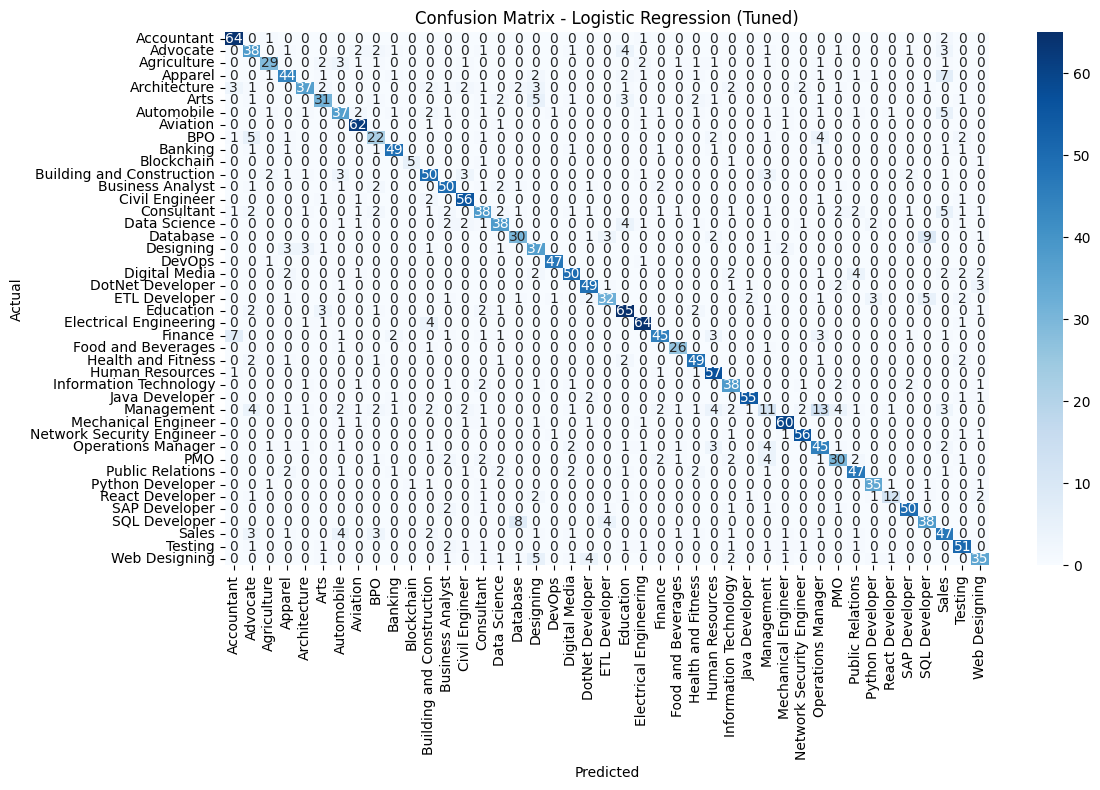

In [ ]:
best_predictions = best_model.predict(X_test)
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Save model
os.makedirs('models', exist_ok=True)
joblib.dump(best_model, 'models/resume_classifier_tuned.pkl')
joblib.dump(label_encoder, 'models/label_encoder.pkl')
with open('models/sentence_model_name.txt', 'w') as f:
    f.write('all-MiniLM-L6-v2')

model_info = {
    'model_type': best_model_name,
    'accuracy': best_accuracy,
    'embedding_dim': X.shape[1],
    'num_classes': len(label_encoder.classes_),
    'classes': label_encoder.classes_.tolist()
}
with open('models/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)


Resume Prediction Function

In [ ]:
def predict_resume_category(resume_text, model_path='models/resume_classifier_tuned.pkl',
                            label_encoder_path='models/label_encoder.pkl'):
    classifier = joblib.load(model_path)
    label_encoder = joblib.load(label_encoder_path)
    cleaned_text = clean_resume_text(resume_text)
    embedding = model.encode([cleaned_text])
    prediction = classifier.predict(embedding)[0]
    prediction_proba = classifier.predict_proba(embedding)[0]
    predicted_category = label_encoder.inverse_transform([prediction])[0]
    sorted_predictions = sorted(
        {label_encoder.classes_[i]: prob for i, prob in enumerate(prediction_proba)}.items(),
        key=lambda x: x[1], reverse=True
    )
    return {
        'predicted_category': predicted_category,
        'confidence': prediction_proba[prediction],
        'top_3_predictions': sorted_predictions[:3],
        'all_predictions': sorted_predictions
    }


Example Resume Prediction

In [ ]:
custom_resume = """
Data Scientist with 3 years of experience in machine learning and data analysis.
Skilled in Python, R, SQL, and various ML algorithms including Random Forest,
SVM, and Neural Networks. Experience with data visualization tools like Tableau
and matplotlib. Worked on predictive modeling projects and statistical analysis.
Strong background in statistics and mathematics. Experience with cloud platforms
like AWS and GCP.
"""

result = predict_resume_category(custom_resume)
print("Predicted Category:", result['predicted_category'])
print("Confidence:", result['confidence'])
print("\nTop 3 Predictions:")
for i, (cat, conf) in enumerate(result['top_3_predictions'], 1):
    print(f"{i}. {cat}: {conf:.4f}")


Predicted Category: Data Science
Confidence: 0.6696492754831201

Top 3 Predictions:
1. Data Science: 0.6696
2. Python Developer: 0.2924
3. ETL Developer: 0.0088
